Generative Adversarial Network trained on a probability distribution

Original Author: Rowel Atienza

Code modified by [Anonymised due to essay requirements]

First we import the necessary libraries:

In [4]:
import numpy as np
import time
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape, LeakyReLU, Dropout
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt

Using TensorFlow backend.


Here we define our GAN object.

This defines the discriminator and generator, in addition to the optimisation algorithms.

In [33]:
class GAN(object):
    #This is a toy dense net GAN which learn 1-d distributions
    def __init__(self):
        #Initalise the Generator and Discriminator
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

        self.discriminator =  self.discriminator_model()
        self.adversarial = self.adversarial_model()
        self.generator = self.init_generator()
        

    #The real function for some distributions for plotting purposes
    def exp(self,t):
        return 0.5*np.exp(-t/2)
    def Norm(self,t,mu=7, s=0.8):
        return (1/(np.sqrt(np.pi*2)*s))*np.exp(-(t-mu)**2/(2*s*s))
    def bimodal(self,t):
        return (f2(t, 8, 0.5)+f2(t, 4, 0.5))/2
    
    
    def generateData(self, batch , dist = "Norm"):
        #This function samples from various true distributions, in order to create training data
        if dist == "Norm":
            d=np.random.normal(loc=7, scale=0.8,size=[batch,32])
            return d
        elif dist == "Exp":
            d=np.random.exponential(scale=2, size=[batch,32])
            return d
        elif dist == "Bimodal":
            d1=np.random.normal(loc=8, scale=0.5, size=int(32*batch/2))
            d2=np.random.normal(loc=4, scale=0.5, size=int(32*batch/2))
            d = np.append(d1, d2)
            np.random.shuffle(d)
            
            return np.reshape (d,[batch, 32])
        
    def generateFakeData(self,batch_size):
        #This function samples from the generated distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 64])
        return self.generator.predict([noise])
    

    def train(self, train_steps=2000, batch_size=1024, k=5, k2=5, plottime=250):
        #This is effectively algorithm 1 in the essay, with the heuristic game instead of the minimax game
        for i in range(train_steps):
            #This is the training loop for the discriminator
            for j in range(k):
                #sample from true distribution
                data_train = self.generateData(batch_size, "Exp")
                #sample from fake distribution
                data_fake= self.generateFakeData(batch_size)
                
                #Create training data
                x = np.concatenate((data_train, data_fake))
                y = np.ones([2*batch_size, 1])
                y[batch_size:, :] = 0
                
                #Train the Discriminator
                d_loss = self.discriminator.train_on_batch(x, y)
                
                
            for j in range(k2):
                #Choose labels to be 1. 
                #Plugging this into the cross entropy mean the objective for the generator maximises Log(D(G(x)))
                #This is the heuristic game which gives us better gradients early in training
                
                y = np.ones([batch_size, 1])
                noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 64])
                a_loss = self.adversarial.train_on_batch(noise, y)
        
            #Print log message
            log_mesg = "%d: [D loss: %f]" % (i, d_loss[0])
            log_mesg = "%s  [A loss: %f]" % (log_mesg, a_loss[0])
            
            #Print mean, variance to assess performance
            dat = self.generateFakeData(100)
            print(log_mesg+" [Mean: {}, S.D: {}]".format (np.mean(dat), np.std(dat)),end='\r')
            
            #Periodically prints histogram to record progress
            if i%plottime==0:
                self.plothist(1000, func = self.exp,title="GAN Learning Exponential Distribution with scale 2 - {} training steps".format(i))

    def plothist(self, size, func, fake=True,title="Histogram with 'auto' bins"):
        #Generate historgram by sampling from either the true or generated distribution
        #This allows for performance to be assessed
        
        #plots real distribution
        x=np.arange(0., 12., 0.01)
        y = [func(i) for i in x]        
    
        if fake:
            #Plots histrogram with data generated from generator
            plt.plot(x,y)
            plt.hist(self.generateFakeData(size).flatten(), bins='auto', density=True)  # arguments are passed to np.histogram
            plt.title(title)
            plt.show()
        else:
            #Plots histrogram with data generated true distribution
            plt.hist(np.asarray(self.generateData(size)).flatten(), bins='auto', density=True)  # arguments are passed to np.histogram
            plt.title(title)
            plt.show()

    
    def init_discriminator(self):
        #Defines the discriminator -- This is a densenet with sigmoid activations
        #The prior is a random vector
        self.D = Sequential()
        dropout = 0.4
        #input is 32 samples from either a true or fake distribution
        self.D.add(Dense(32, input_dim=32))
        self.D.add(Activation('sigmoid'))
        self.D.add(Dropout(dropout))

        self.D.add(Dense(32))
        self.D.add(Activation('sigmoid'))
        self.D.add(Dropout(dropout))
        
        self.D.add(Dense(32))
        self.D.add(Activation('sigmoid'))
        self.D.add(Dropout(dropout))

        self.D.add(Dense(1))
        #one final sigmoind to ensure that the output is a probability
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D
    
    def bigtanh(self,x):
        #We use this scaled tanh as the output rule to shift the range to [0,12] from [0,1]
        return (K.tanh(x)*6+6)
    
    def init_generator(self):
        #Defines the discriminator -- attempts to generate a vector of uniformly distributed distributions
        #This is a densenet with ReLU activations
        self.G = Sequential()
        dropout = 0.4

        self.G.add(Dense(64, input_dim=64))
        self.G.add(LeakyReLU(alpha=0.2))
        self.G.add(Dropout(dropout))
        
        
        self.G.add(Dense(32))
        self.D.add(LeakyReLU(alpha=0.2))
        self.G.add(Dropout(dropout))
        

        self.G.add(Dense(32))
        #Custom output to ensure that that the output is on the correct domain
        self.G.add(Activation(self.bigtanh))
        self.G.add(Dropout(dropout))

        self.G.summary()
        return self.G

    def discriminator_model(self):
        #Defines the optimiser objective for the discriminator
        #We use the adam gradient method for both networks
        optimizer = Adam(lr=0.0006, decay=15e-8)
        self.DM = Sequential()
        self.DM.add(self.init_discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        #Defines the objective for the generator
        #We use the adam gradient method for both networks
        optimizer = Adam(lr=0.0003, decay=10e-8)
        self.AM = Sequential()
        self.AM.add(self.init_generator())
        self.AM.add(self.init_discriminator())
        #Note that we nest the generator and dicriminator -- this means the objective is defined in terms of the discriminator
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM                 
             
  

Call our GAN object -- these are the hyperparameters.

In [34]:
DISTGAN = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_125 (Dense)            (None, 32)                1056      
_________________________________________________________________
activation_95 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 32)                1056      
_________________________________________________________________
activation_96 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_110 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_127 (Dense)            (None, 32)                1056      
__________

Here we have some different outputs.

Note that each of these require different hyperparameters, so running the program yourself likely have different results.

The code is currently set up to learn the exponential distribution. To learn the other distributions will require changing a large number of parameters within the object.

Learning an exponential distribution:

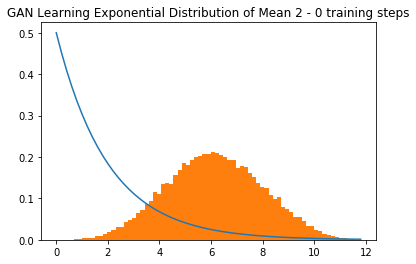

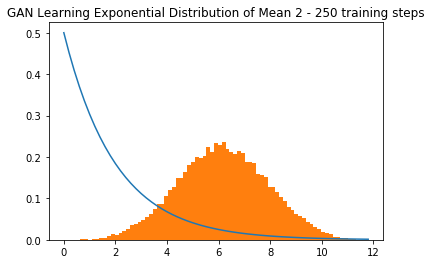

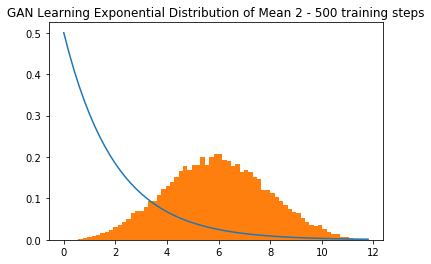

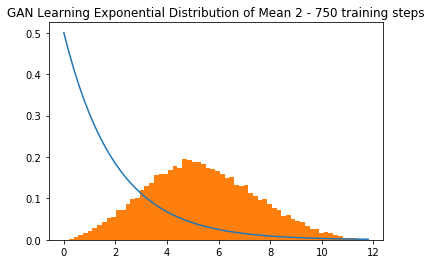

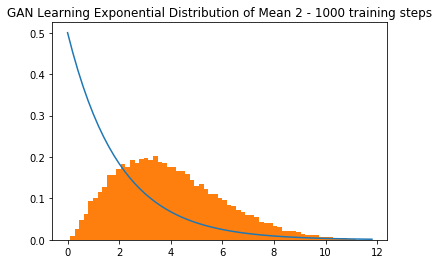

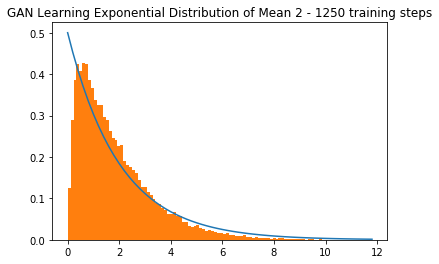

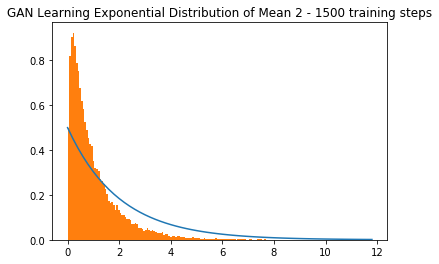

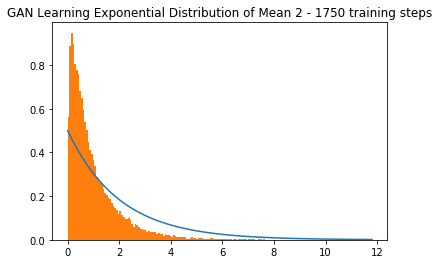

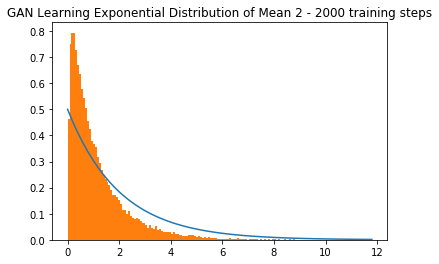

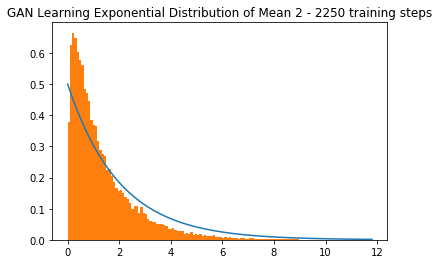

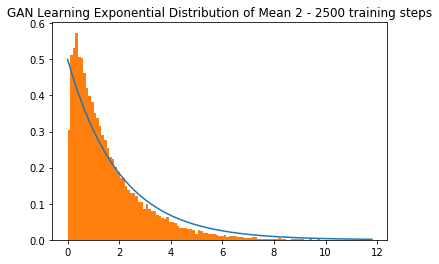

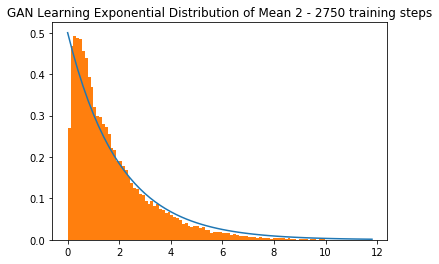

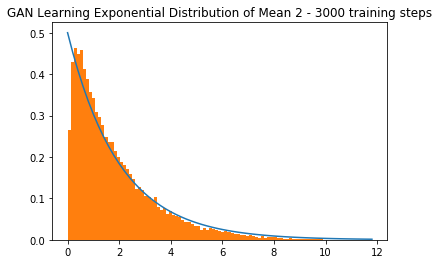

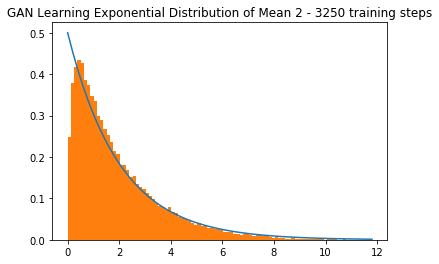

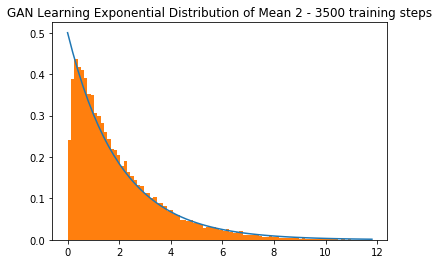

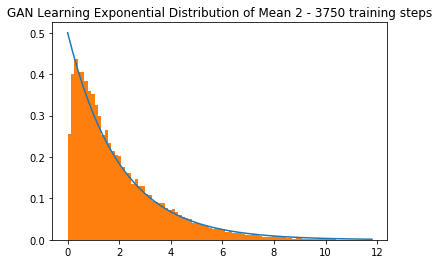

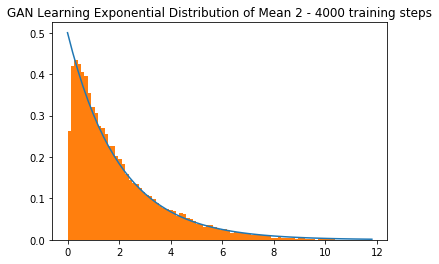

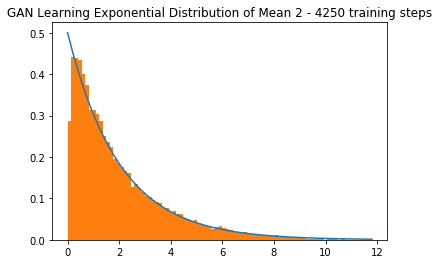

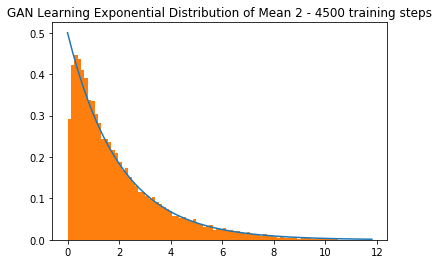

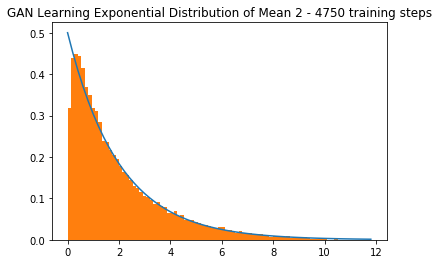

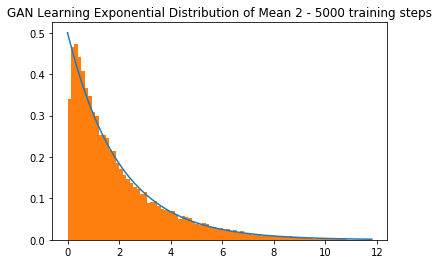

KeyboardInterrupt: 

In [43]:
steps=20000
DISTGAN.train(train_steps=steps, batch_size=1024, k=1, k2=1)

Learning a Normal distribution:

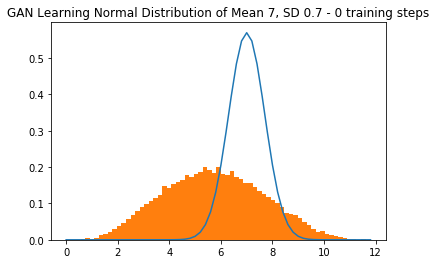

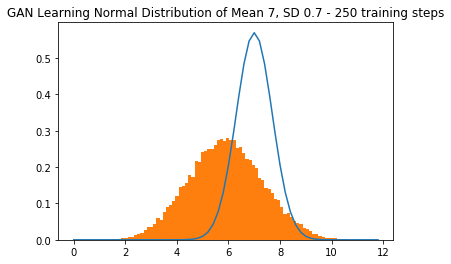

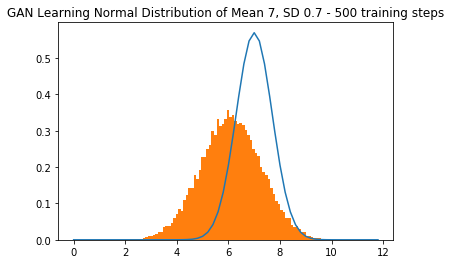

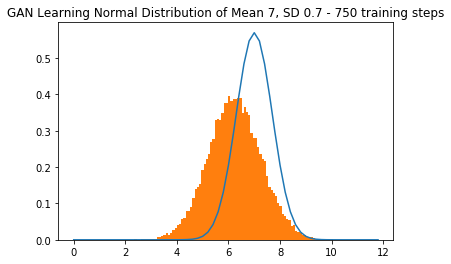

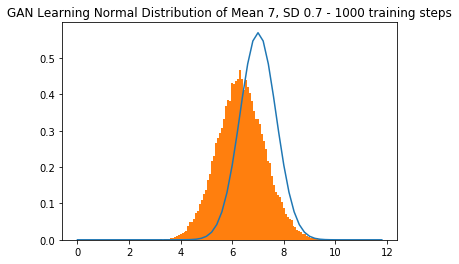

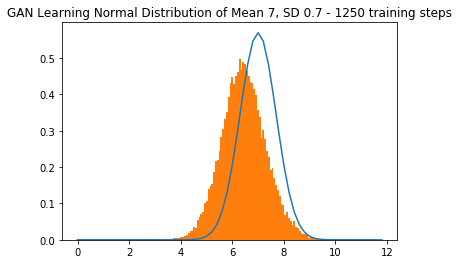

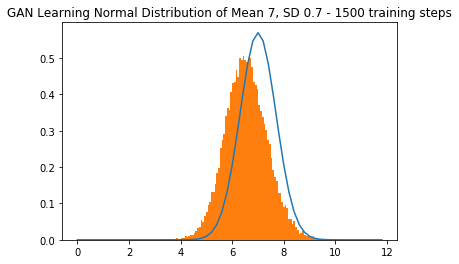

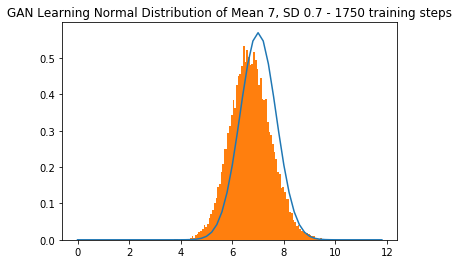

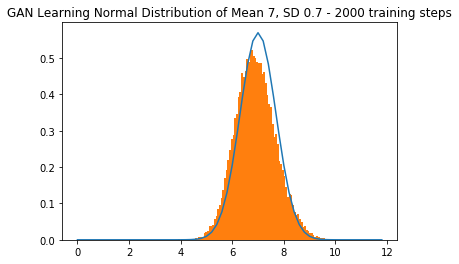

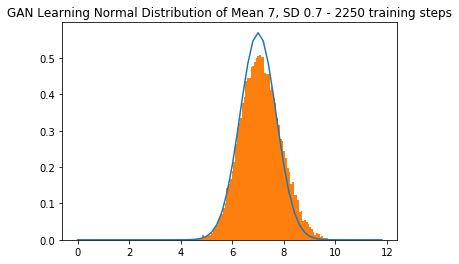

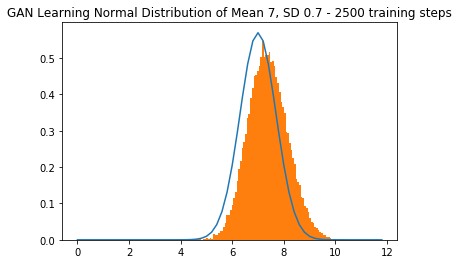

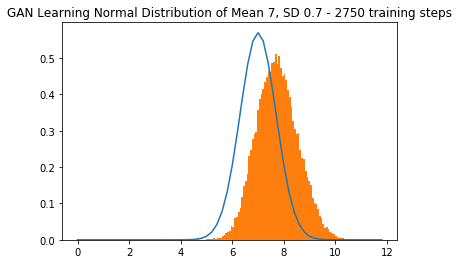

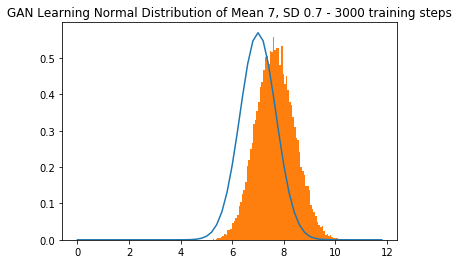

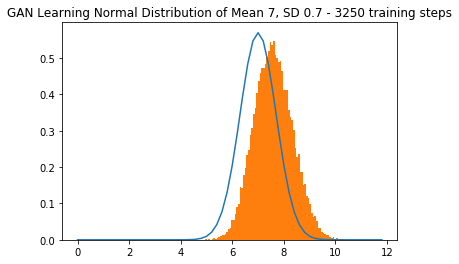

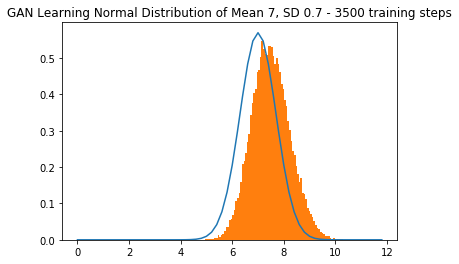

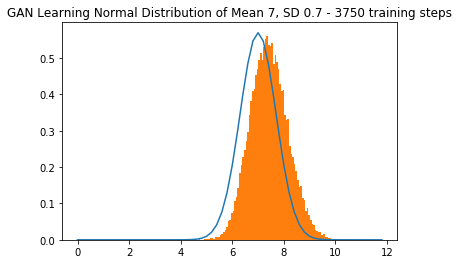

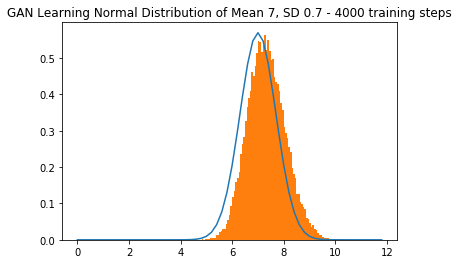

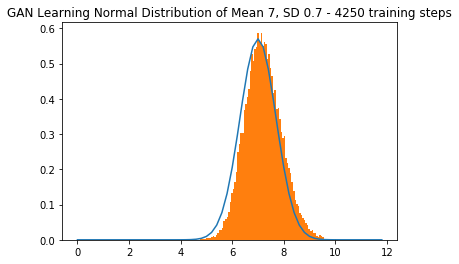

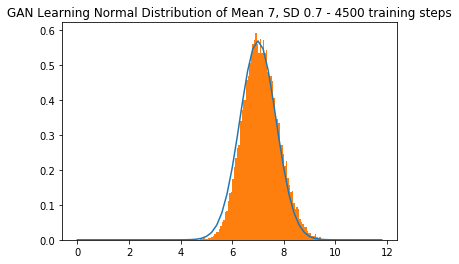

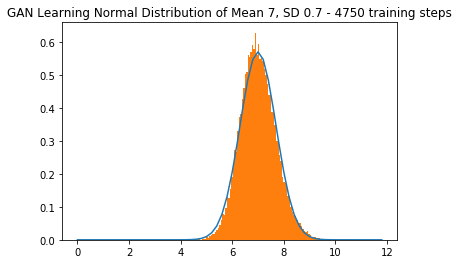

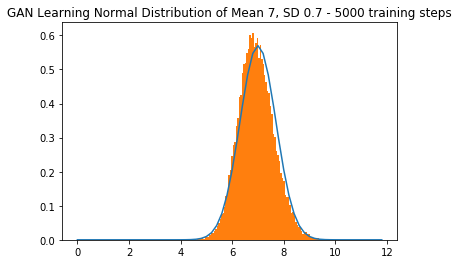

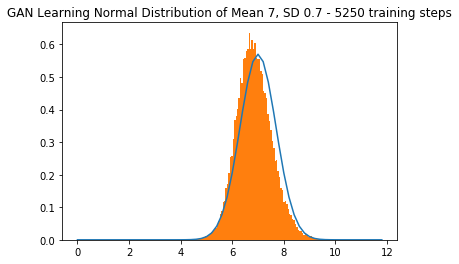

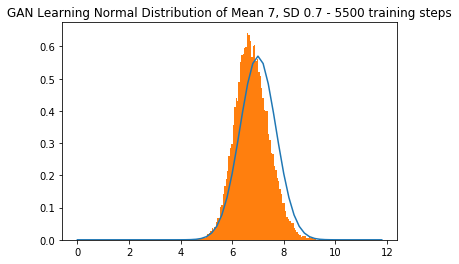

KeyboardInterrupt: 

In [167]:
steps=20000
DISTGAN.train(train_steps=steps, batch_size=1024, k=5, k2=1)

Mode collapse when learning a bimodal function

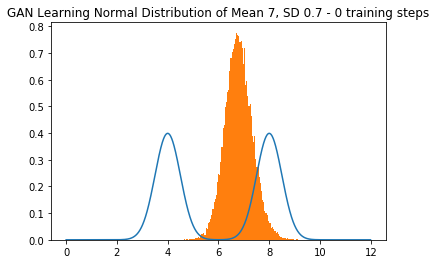

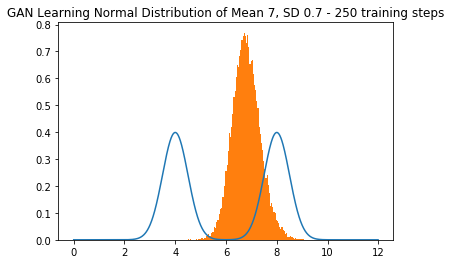

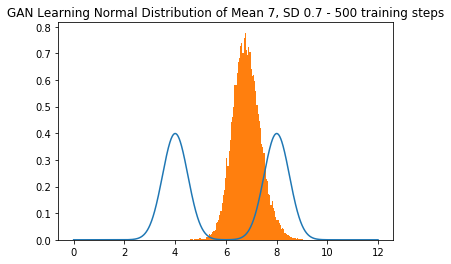

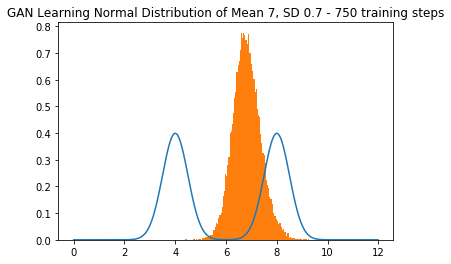

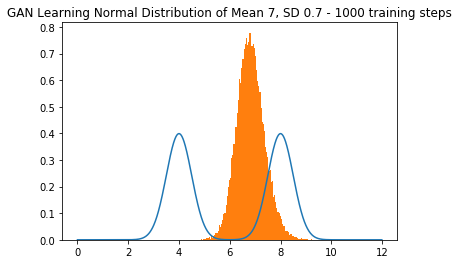

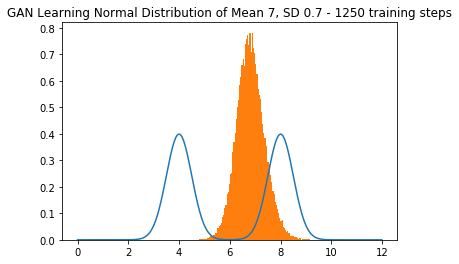

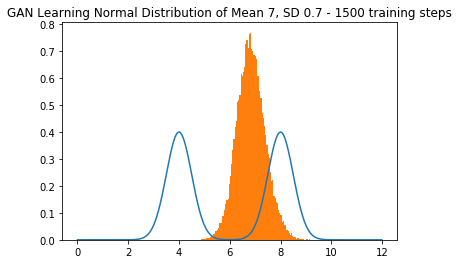

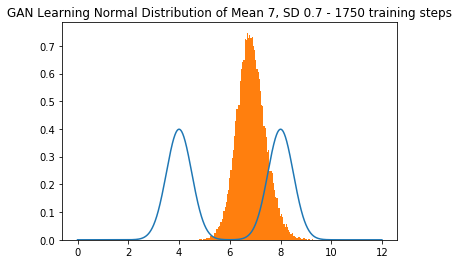

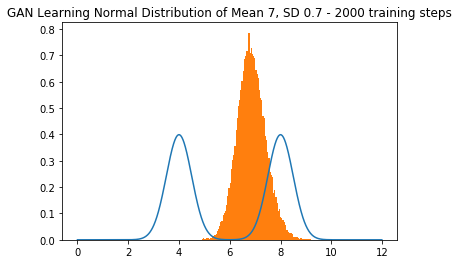

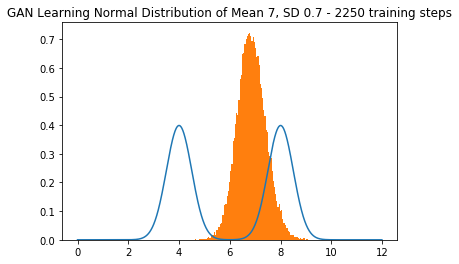

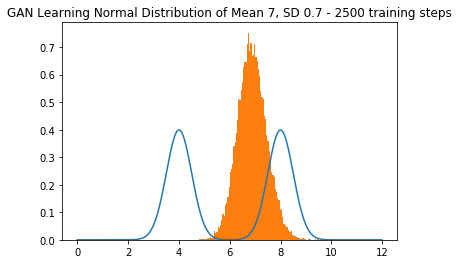

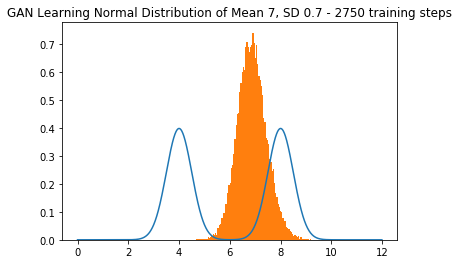

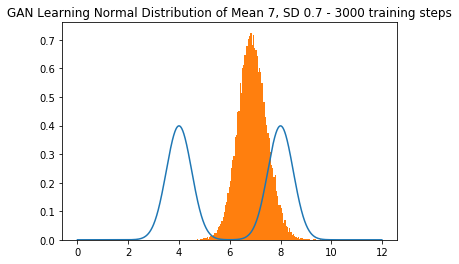

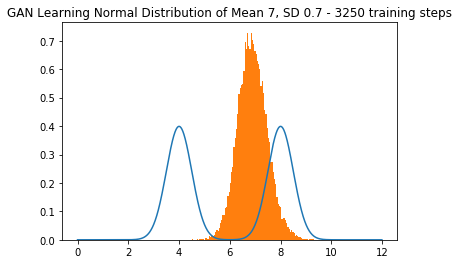

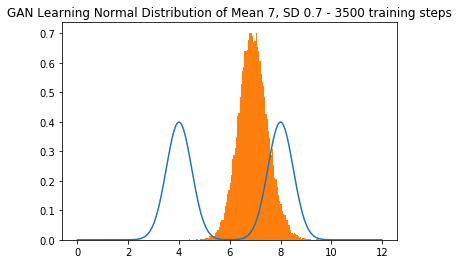

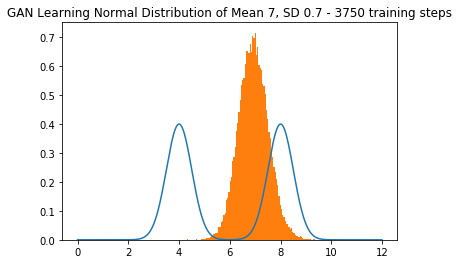

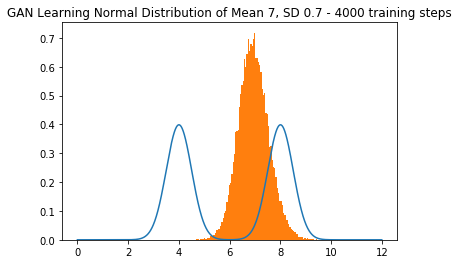

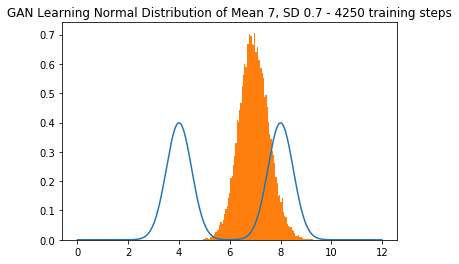

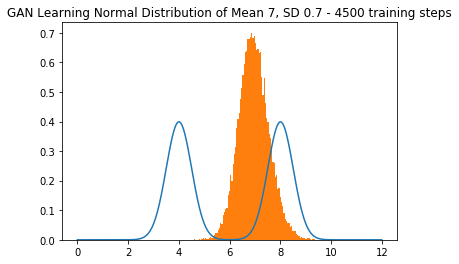

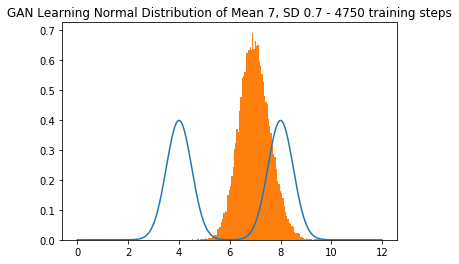

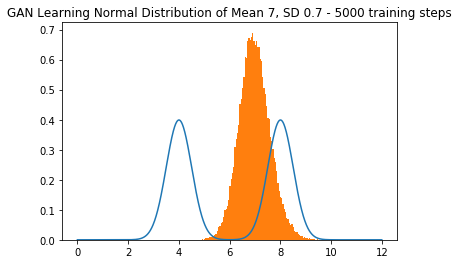

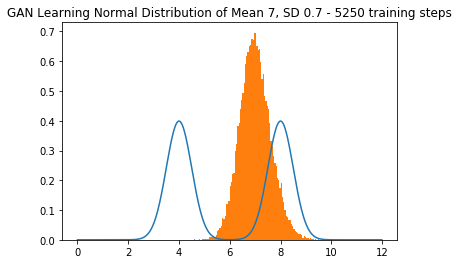

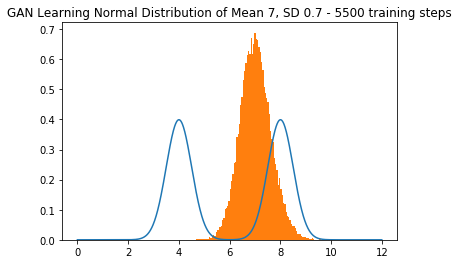

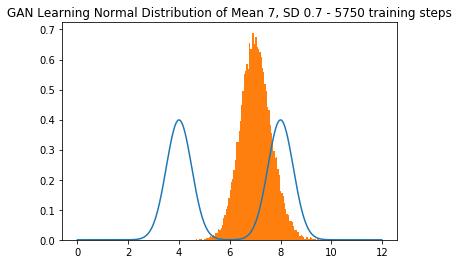

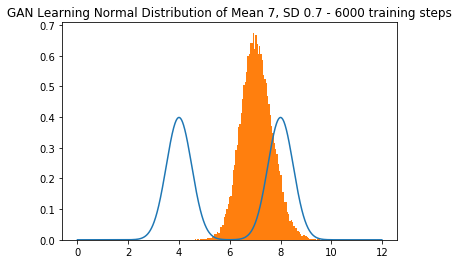

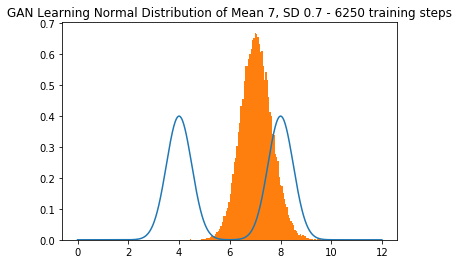

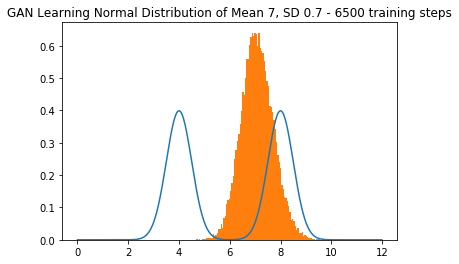

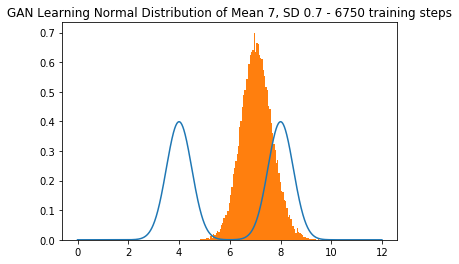

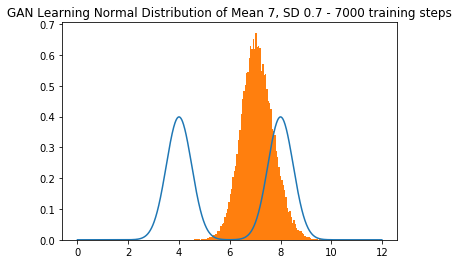

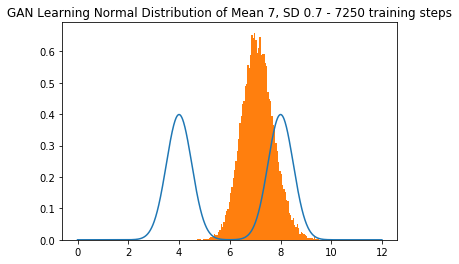

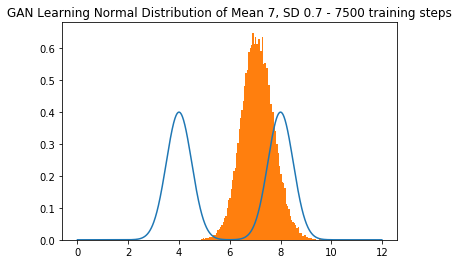

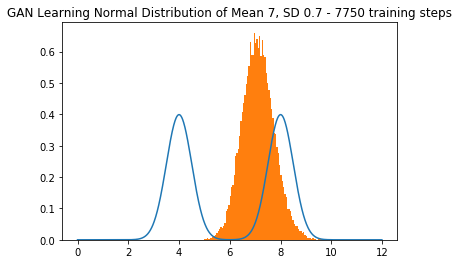

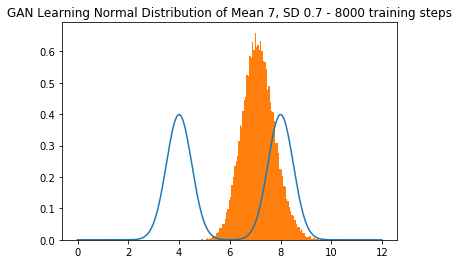

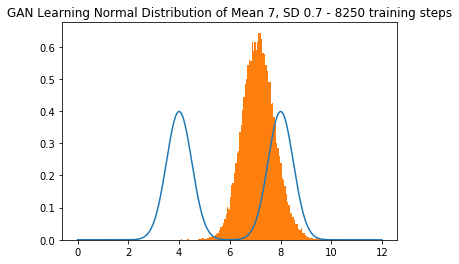

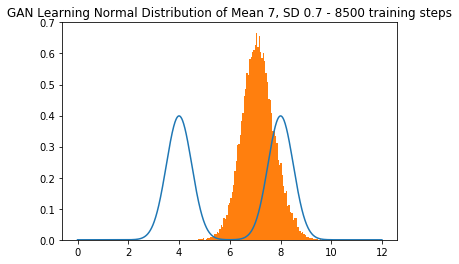

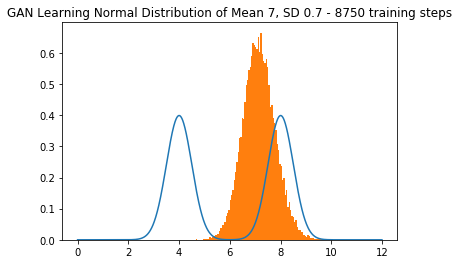

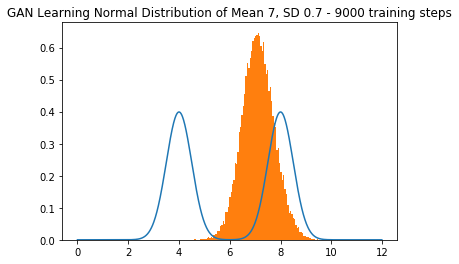

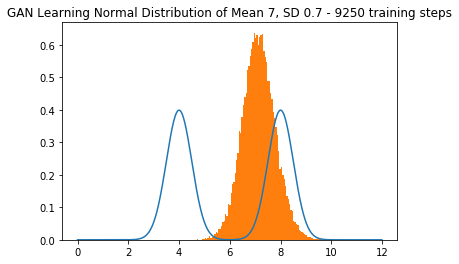

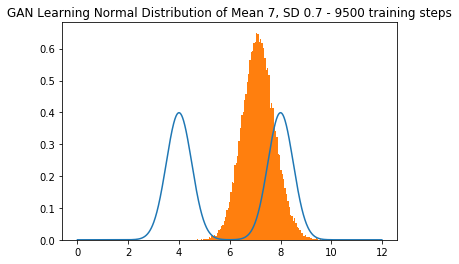

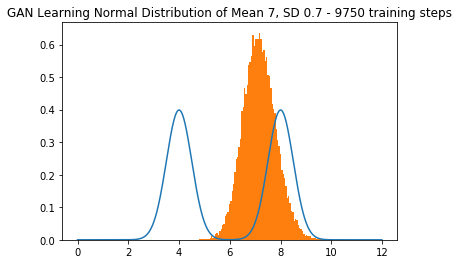

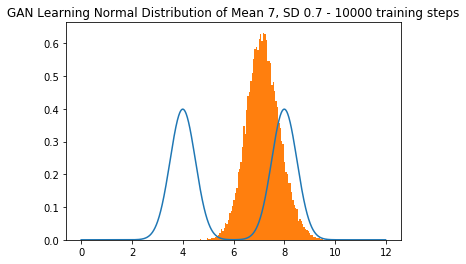

In [11]:
steps=10100
DISTGAN.train(train_steps=steps, batch_size=1024, k=3, k2=1)